In [152]:
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from os.path import dirname, join
current_dir = dirname("__file__")

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.3')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [153]:
data = pd.read_csv("./dummy_data.csv", index_col=0)
data.index = pd.to_datetime(data.index)
pymc_df  = data

df = data[["_Raw_Data"]].dropna()
df['X'] = df.index.values.astype('Int64')

In [154]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df['X_training'] = scaler.fit_transform(df.X.values.reshape(-1,1))


In [155]:
df['X_training']

2020-03-27 00:00:00+00:00   -1.593255
2020-03-28 00:00:00+00:00   -1.303572
2020-03-29 00:00:00+00:00   -1.013890
2020-03-30 00:00:00+00:00   -0.724207
2020-03-31 00:00:00+00:00   -0.434524
2020-04-01 00:00:00+00:00   -0.144841
2020-04-02 00:00:00+00:00    0.144841
2020-04-03 00:00:00+00:00    0.434524
2020-04-04 00:00:00+00:00    0.724207
2020-04-05 00:00:00+00:00    1.013890
2020-04-06 00:00:00+00:00    1.303572
2020-04-07 00:00:00+00:00    1.593255
Name: X_training, dtype: float64

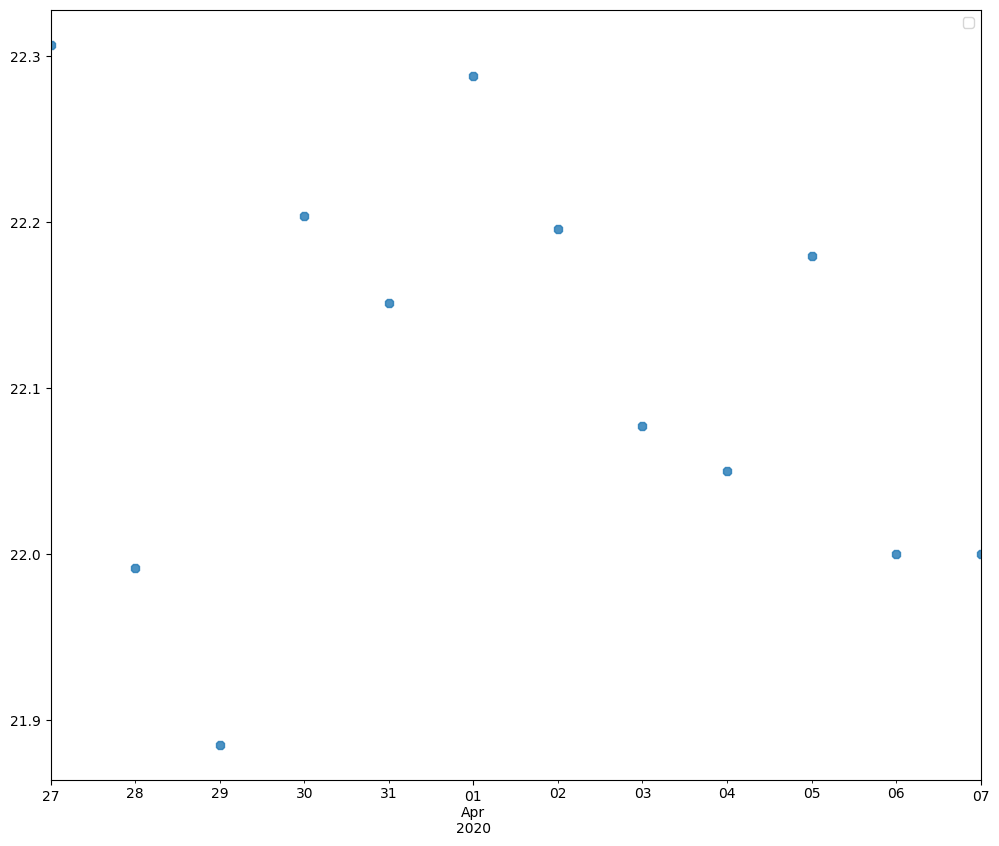

In [156]:
df[["_Raw_Data"]].plot(style="8", alpha=0.8, figsize=(12, 10))

In [157]:
df.columns

Index(['_Raw_Data', 'X', 'X_training'], dtype='object')

In [158]:
df = df[['X_training', '_Raw_Data']]

In [159]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)


In [160]:
data = torch.tensor(df.values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

# Regression model
linear_reg_model = PyroModule[nn.Linear]((len(df.columns)-1), 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 4865.2739
[iteration 0100] loss: 3801.4648
[iteration 0150] loss: 2925.5505
[iteration 0200] loss: 2215.2175
[iteration 0250] loss: 1648.5319
[iteration 0300] loss: 1204.4106
[iteration 0350] loss: 862.9468
[iteration 0400] loss: 605.7369
[iteration 0450] loss: 416.1617
[iteration 0500] loss: 279.6061
[iteration 0550] loss: 183.5718
[iteration 0600] loss: 117.6983
[iteration 0650] loss: 73.6594
[iteration 0700] loss: 44.9834
[iteration 0750] loss: 26.8068
[iteration 0800] loss: 15.5963
[iteration 0850] loss: 8.8716
[iteration 0900] loss: 4.9491
[iteration 0950] loss: 2.7254
[iteration 1000] loss: 1.5005
[iteration 1050] loss: 0.8452
[iteration 1100] loss: 0.5047
[iteration 1150] loss: 0.3331
[iteration 1200] loss: 0.2492
[iteration 1250] loss: 0.2094
[iteration 1300] loss: 0.1911
[iteration 1350] loss: 0.1830
[iteration 1400] loss: 0.1795
[iteration 1450] loss: 0.1780
[iteration 1500] loss: 0.1774
Learned parameters:
weight [[-0.02804587]]
bias [22.10544]


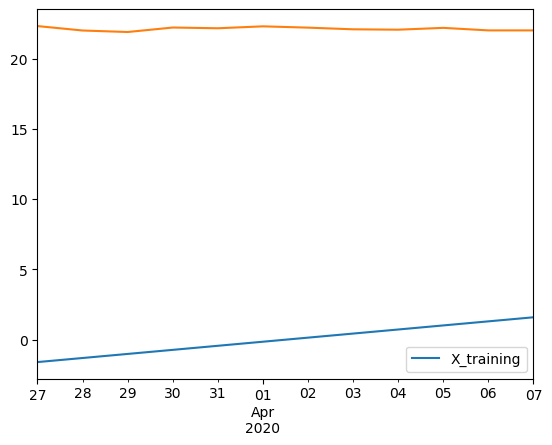

In [161]:
#Plotting regression fit
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

df.plot()

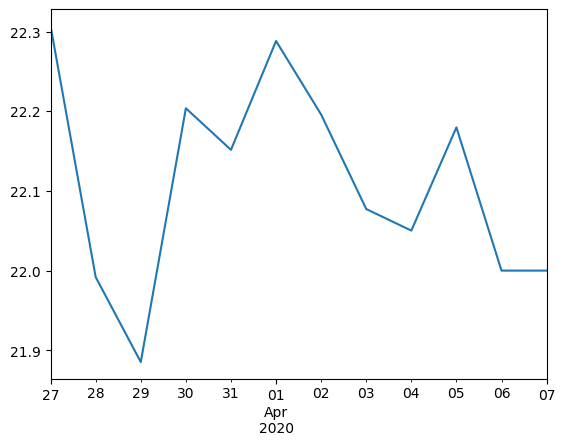

In [162]:
from pyro.nn import PyroSample


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [163]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression((len(df.columns)-1), 1)
guide = AutoDiagonalNormal(model)

In [164]:

from pyro.infer import SVI, Trace_ELBO


adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [140]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 8.9555
[iteration 0101] loss: 5.5448
[iteration 0201] loss: 4.8561
[iteration 0301] loss: 4.6765
[iteration 0401] loss: 3.9637
[iteration 0501] loss: 4.5190
[iteration 0601] loss: 3.9993
[iteration 0701] loss: 3.7022
[iteration 0801] loss: 3.6170
[iteration 0901] loss: 3.6503
[iteration 1001] loss: 3.2701
[iteration 1101] loss: 3.1078
[iteration 1201] loss: 2.8222
[iteration 1301] loss: 1.8291
[iteration 1401] loss: 1.7976


In [141]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-3.8169, -0.0941, 22.2681])
AutoDiagonalNormal.scale tensor([0.2378, 0.0597, 0.0585])


In [142]:

guide.quantiles([0.25, 0.5, 0.75])

{'sigma': [tensor(0.1839), tensor(0.2152), tensor(0.2517)],
 'linear.weight': [tensor([[-0.1344]]),
  tensor([[-0.0941]]),
  tensor([[-0.0538]])],
 'linear.bias': [tensor([22.2286]), tensor([22.2681]), tensor([22.3075])]}

In [143]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [144]:

mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "date": df.index.values,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
})

In [150]:
predictions.head()

,_Raw_Data,mu_mean,mu_perc_5,mu_perc_95,y_mean,y_perc_5,y_perc_95
date,,,,,,,
2020-03-27 00:00:00+00:00,22.306838,22.417086,22.218241,22.602703,22.423801,22.006853,22.849319
2020-03-28 00:00:00+00:00,21.991895,22.389870,22.213787,22.548431,22.391712,21.984632,22.780970
2020-03-29 00:00:00+00:00,21.885219,22.362656,22.212032,22.499712,22.364256,22.011976,22.762468
2020-03-30 00:00:00+00:00,22.203699,22.335442,22.208082,22.453230,22.323553,21.949026,22.711754
2020-03-31 00:00:00+00:00,22.151539,22.308201,22.199007,22.413902,22.305664,21.911121,22.682207


In [151]:
predictions = predictions.set_index('date').tz_localize('UTC').join(df, how='inner')
predictions = predictions[['_Raw_Data', 'mu_mean', 'mu_perc_5', 'mu_perc_95', 'y_mean', 'y_perc_5', 'y_perc_95']]


KeyError: "None of ['date'] are in the columns"

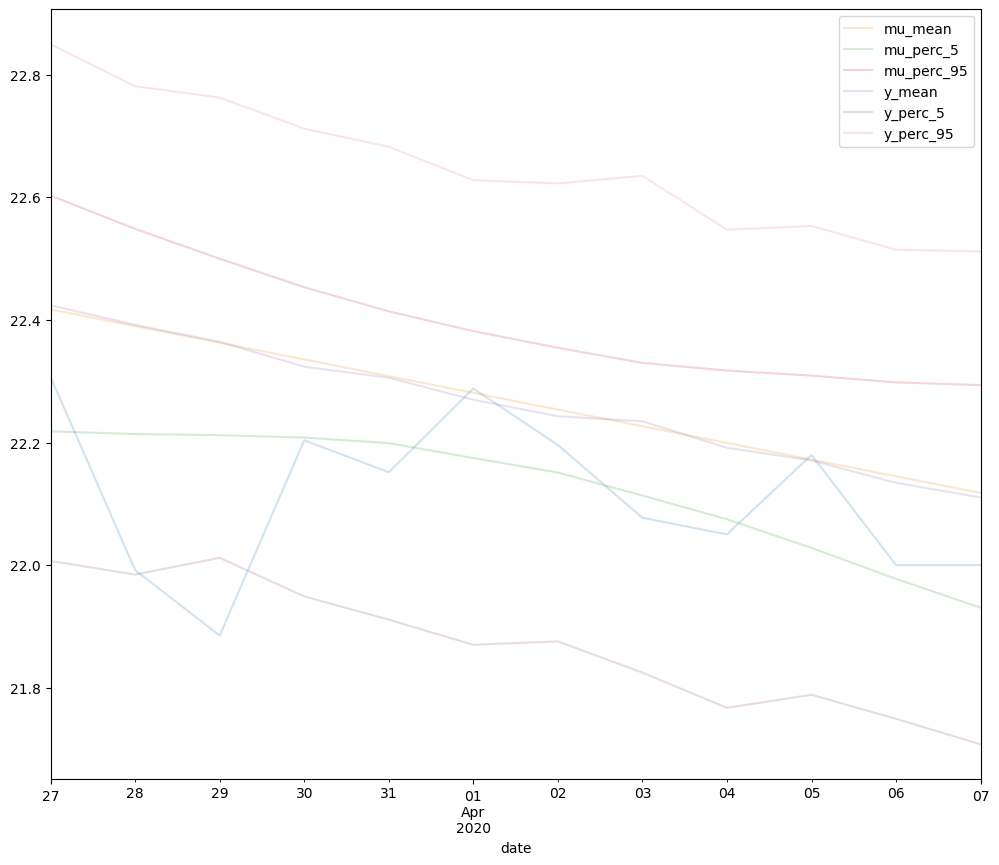

In [149]:
predictions.plot(figsize=(10, 12), alpha=0.2, style="8", subplots=True)

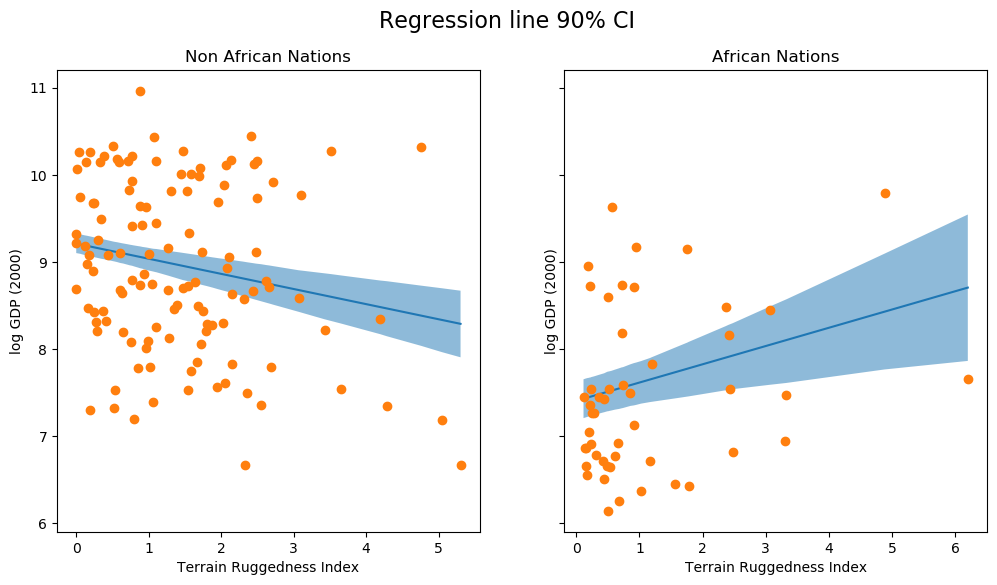

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

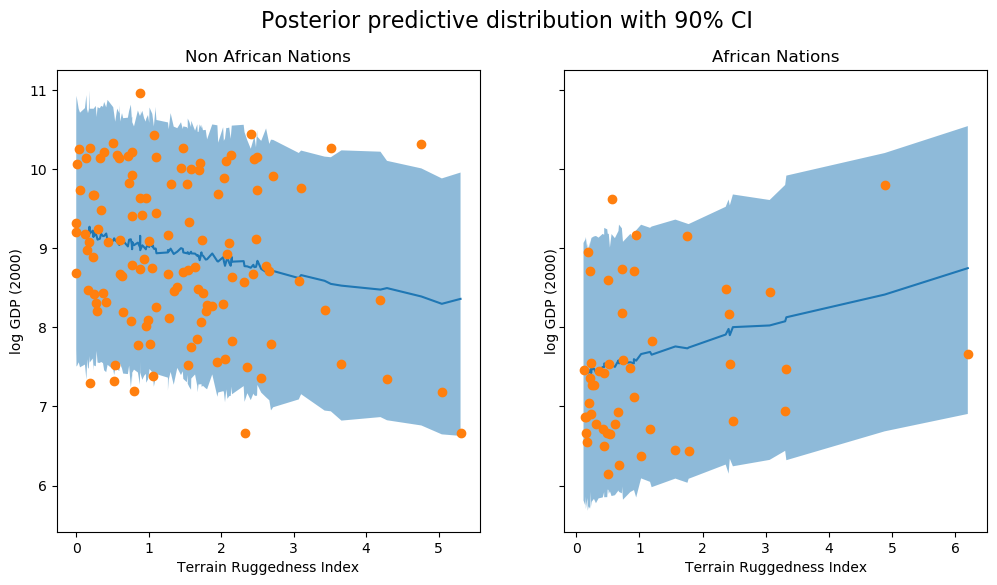

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");